<a href="https://colab.research.google.com/github/WFirmin/Math/blob/main/Math.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimization Methods


## Line Search Methods
I test each method with the same function to approximate the square root of 2:

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
import time

g = lambda x: (x**2-2)**2
dg = lambda x: 4*x**3-8*x
d2g = lambda x: 12*x**2-8
print(math.sqrt(2))

X = np.linspace(0,2,100)
Y = list(map(g,X))

1.4142135623730951


### Golden Section
Assumes $f(x)$ is unimodal: only one local minimizer on $[a,b]$

In [ ]:
def GoldenSection(f,a,b, tol=0, N=100, interval=False):
    # f is a function to minimize, [a,b] is the range to minimize over

    # Define range and find number of necessary iterations (if not specified)
    R = b-a
    p = (3-math.sqrt(5))/2
    if tol > 0:
        N = math.ceil(math.log(tol/R, 1-p))

    # Set initial conditions
    p0,q0 = (a,f(a)),(b,f(b))
    p1,q1 = a+p*R, b-p*R
    p1,q1 = (p1, f(p1)),(q1,f(q1))

    # Iterate and update search range
    for n in range(N):
        if p1[1] < q1[1]:
            q0,q1 = q1,p1
            p1 = p0[0]+p*(q0[0]-p0[0])
            p1 = (p1,f(p1))
        else:
            p0,p1 = p1,q1
            q1 = q0[0]-p*(q0[0]-p0[0])
            q1 = (q1,f(q1))
    return (p0[0],q0[0]) if interval else p0[0]

GoldenSection(g,0,5, interval=True)


(1.4142135623730951, 1.4142135623730954)

### Fibonacci Method
Same assumptions as before

In [ ]:
# Useful functions:

def Fibonacci(n):
    n = n+1
    return ((1+math.sqrt(5))**n - (1-math.sqrt(5))**n) / (2**n * math.sqrt(5))

def invFibonacci(F):
    if F < 2: return 1
    return round(math.log(math.sqrt(5)*(F-0.5),(1+math.sqrt(5))/2))-1

def pFib(k,N):
    if k == 1: return 1 - Fibonacci(N)/Fibonacci(N+1)
    elif k == N: return 0.5-0.00001
    else: return 1 - Fibonacci(N-k+1)/Fibonacci(N-k+2)

# Main function:

def FibonacciMethod(f,a,b,tol=0,N=100,interval=False):
    # Define range and find number of necessary iterations (if not specified)
    R = b-a
    if tol > 0:
        N = invFibonacci(R/tol) # +/- 1
        # R/tol < fibN+1

    # Set initial conditions
    p = pFib(1,N)
    p0,q0 = (a,f(a)),(b,f(b))
    p1,q1 = a+p*R, b-p*R
    p1,q1 = (p1, f(p1)),(q1,f(q1))

    # Iterate and update search range
    for k in range(2,N+1):
        p = pFib(k,N)
        if p1[1] < q1[1]:
            q0,q1 = q1,p1
            p1 = p0[0]+p*(q0[0]-p0[0])
            p1 = (p1,f(p1))
        else:
            p0,p1 = p1,q1
            q1 = q0[0]-p*(q0[0]-p0[0])
            q1 = (q1,f(q1))
    return (p0[0],q0[0]) if interval else p0[0]

FibonacciMethod(g,0,5,interval=True)

(1.4142135623730951, 1.4142135623730954)

### Bisection Method
Same assumptions but also requires the derivative to be known

In [ ]:
def BisectionMethod(df,a,b,tol=0,N=100,interval=False):
    # Define range and find necessary number of iterations (if not specified)
    R = b-a
    if tol>0:
        N = math.ceil(math.log(tol/R, 0.5))

    # Set initial conditions
    p,q = a,b

    # Iterate and update search range
    for k in range(N):
        x = (p+q)/2
        if df(x) < 0:
            p = x
        elif df(x) > 0:
            q = x
        else:
            return (x,x)
    return (p,q) if interval else p

BisectionMethod(dg,0,5, interval=True)

(1.414213562373095, 1.4142135623730951)

### Newton's Method (1D)
Requires second order derivative as well

In [ ]:
def NewtonsMethod(df,d2f,x0,tol=0,N=100,log=False):
  x,x0 = x0,math.inf
  past = [x]
  iter = 0
  while abs(x-x0) > tol and iter < N:
    x0 = x
    x = x - df(x)/d2f(x)
    iter += 1
    if log: past.append(x)
  return x if not log else np.array(past)

NewtonsMethod(dg,d2g,1)


1.4142135623730951

## Descent Methods

### Gradient Descent

In [ ]:
# parameters are gradient, step size (function), and starting position
def GradientDescent(df, stepsize, x0, tol=0, N=100, log=False, momentum=0):
  x,x0 = np.array(x0),math.inf
  d0 = 0*x
  past = [x]
  iter = 0
  while np.sqrt(((x-x0)**2).sum()) > tol and iter < N:
    x0 = x
    d = stepsize(x,iter,df)*df(x) + momentum * d0
    x = x - d
    d0 = d
    iter += 1
    if log: past.append(x)
  return x if not log else np.array(past)

# Fixed Step-Size
step = lambda x,t,df: 0.01
print(GradientDescent(dg, step, 1))


# Steepest Descent
def SteepestDescent(x,t,f,df,range):
  h = lambda a: f(x-a*df(x))
  return FibonacciMethod(h,0,range)

step = lambda x,t,df: SteepestDescent(x,t,g,df,2)
print(GradientDescent(dg,step,1))

1.4142135415057158
1.414213562373095


### Conjugate Descent
I use the Fletcher-Reeves formula to avoid calculating the hessian.

In [ ]:
def FletcherReeves(f, df, x0, tol=0, N=100, range=1, log=False):
  x,x0 = np.array(x0),math.inf
  g = df(x)
  d = -g
  past = [x]
  iter = 0
  while np.sqrt(((x-x0)**2).sum()) > tol and iter < N:
    h = lambda a: f(x+a*d)
    a = FibonacciMethod(h, 0, range)
    #print(a)
    x1 = x + a*d
    g1 = df(x1)
    b = g1.dot(g1) / g.dot(g)
    d1 = -g1 +b*d

    x,x0 = x1,x
    g,d = g1,d1
    iter += 1
    if log: past.append(x)
  return x if not log else np.array(past)

#FletcherReeves(k,dk,[0.25,1], range=0.1)

## Comparisons

### One Dimensional Optimization

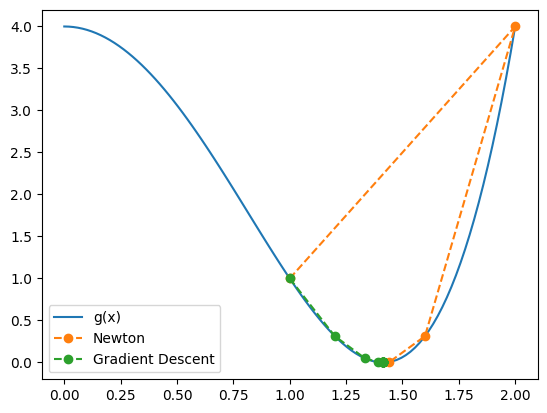

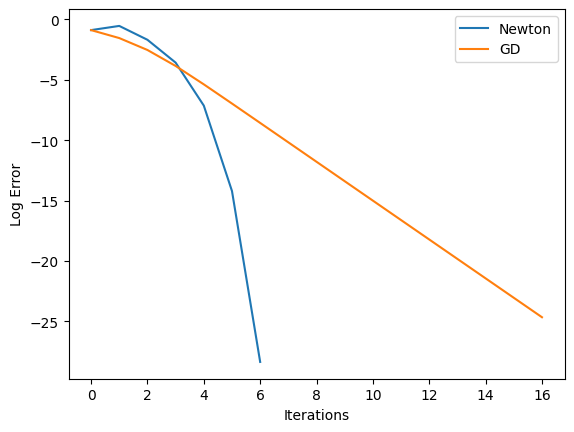

In [ ]:

plt.plot(X,Y,label="g(x)")
tol = 1e-10
m1 = NewtonsMethod(dg,d2g, 1, tol=tol, log=True)
plt.plot(m1,list(map(g,m1)),label="Newton",linestyle='--', marker='o')

step = lambda x,t,df: 0.05
m2 = GradientDescent(dg,step,1, tol=tol, log=True)
plt.plot(m2,list(map(g,m2)),label="Gradient Descent",linestyle="--",marker="o")

plt.legend()
plt.show()

L = lambda X: list(range(len(X)))
plt.plot(L(m1[:-1]),np.log(np.abs(m1-np.sqrt(2))[:-1]), label="Newton")
plt.plot(L(m2),np.log(np.abs(m2-np.sqrt(2))), label="GD")
plt.xlabel("Iterations")
plt.ylabel("Log Error")
plt.legend()
plt.show()

### Multivariable Optimization

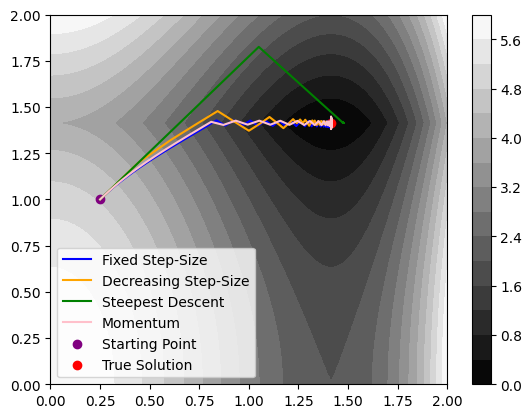

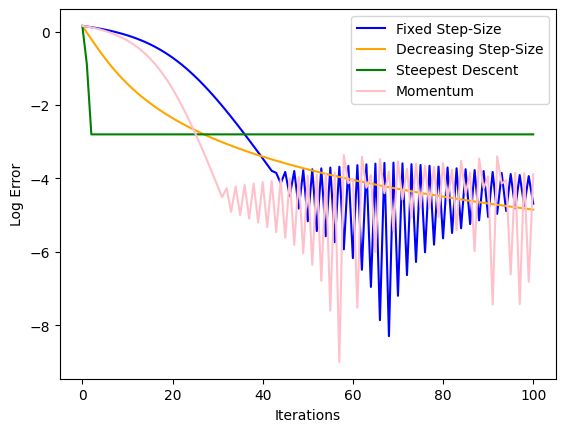

In [ ]:
# multivariable gradient descent:
k = lambda x: g(x[0]) + g(x[1])**0.5
dk = lambda x: np.array([dg(x[0]), 0.5*g(x[1])**(-0.5)*dg(x[1])])
d2k = lambda x: np.array([[d2g(x[0]), 0],
                          [0, -0.25*g(x[1])**(-1.5)*dg(x[1])**2 + 0.5*g(x[1])**(-0.5)*d2g(x[1])]])
step = lambda x,t,df: 0.1/(t+1)
step2 = lambda x,t,df: 0.01
step3 = lambda x,t,df: SteepestDescent(x,t,k,df,2)
start=[0.25,1]

# calculate paths for each algorithm
m3 = GradientDescent(dk,step,start, tol=tol, log=True)
m4 = GradientDescent(dk,step2,start, tol=tol, log=True)
m5 = GradientDescent(dk,step3,start, tol=0, log=True)
m6 = GradientDescent(dk,step2,start, tol=tol, log=True, momentum=0.3)

# create visualization of function
xx,yy = np.meshgrid(X,X)
zz = np.array(list(map(g,xx))) + np.sqrt(list(map(g,yy)))
plt.contourf(xx,yy,zz,15, cmap="gray")
plt.colorbar()

# add algorithms
plt.plot(m4[:,0],m4[:,1], label="Fixed Step-Size", color="blue")
plt.plot(m3[:,0],m3[:,1], label="Decreasing Step-Size", color="orange")
plt.plot(m5[:,0],m5[:,1], label="Steepest Descent", color="green")
plt.plot(m6[:,0],m6[:,1], label="Momentum", color="pink")
plt.scatter([start[0]],[start[1]],color="purple",label="Starting Point")
plt.scatter([np.sqrt(2)],[np.sqrt(2)],label="True Solution",color="red")

plt.legend()
plt.show()

# Visualize error
plt.plot(L(m4),np.log(np.apply_along_axis(np.max, 1, np.abs(m4-np.sqrt([2,2])))),label="Fixed Step-Size", color="blue")
plt.plot(L(m3),np.log(np.apply_along_axis(np.max, 1, np.abs(m3-np.sqrt([2,2])))),label="Decreasing Step-Size",color="orange")
plt.plot(L(m5),np.log(np.apply_along_axis(np.max, 1, np.abs(m5-np.sqrt([2,2])))),label="Steepest Descent",color="green")
plt.plot(L(m6),np.log(np.apply_along_axis(np.max, 1, np.abs(m6-np.sqrt([2,2])))),label="Momentum", color="pink")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Log Error")
plt.show()

# Numerical Methods

## Root Finding (1D)
I again approximate $\sqrt{2}$ using $g(x)=x^2-2$.  The methods are compared theoretically using Q-order convergence.  A method producing a sequence ${x_n}$ has Q-order convergence $s\ge1$ if $$\lim_{n\rightarrow\infty}\frac{|x_n-x^*|}{|x_{n-1}-x^*|^s}=c$$ for $c\in(0,\infty)$.

In [ ]:
g = lambda x: x**2 - 2
dg = lambda x: 2*x

### Fixed Point Iteration (FPI)

In [ ]:
def FPI(f,alpha,x0,tol=0,N=100,log=False):
  x,x0 = x0,math.inf
  iter = 0
  past = [x]
  while abs(x-x0) > tol and iter < N:
    x0 = x
    x = x - alpha*f(x)
    iter += 1
    if log: past.append(x)
  return x if not log else np.array(past)


### Newton's Method
Requires the derivative of the function.  Converges quadratically.

In [ ]:
def NewtonRoot(f,df,x0,tol=0,N=100,log=False):
  x,x0 = x0,math.inf
  iter = 0
  past = [x]
  while abs(x-x0) > tol and iter < N:
    x0 = x
    x = x - f(x)/df(x)
    iter += 1
    if log: past.append(x)
  return x if not log else np.array(past)



### Secant Method
Similar to Newton's method but doesn't require the derivative.  Converges with rate $\frac{1+\sqrt5}2$ (golden ratio).

In [ ]:
def SecantRoot(f,x0,tol=0,N=100,log=False):
  x=x0+0.001
  iter = 0
  past = [x]
  while abs(x-x0) > tol and iter < N:
    try:
      x1 = x - f(x)*(x-x0) / (f(x)-f(x0))
      x,x0 = x1,x
    except ZeroDivisionError: pass
    iter += 1
    if log: past.append(x)
  return x if not log else np.array(past)


### Steffensen's Method
For linearly convergent methods, Aitken Acceleration increases the rate of convergence to a value less than 2.  Using this on fixed point iteration gives Steffensen's Method.


In [ ]:
def Steffensen(f, x0, tol=0, N=100, log=False):
  x,x0 = x0,math.inf
  past = [x]
  iter=0
  while abs(x-x0) > tol and iter < N:
    x0=x
    try: x = x - f(x)**2 / (f(x + f(x)) - f(x))
    except ZeroDivisionError: pass
    iter += 1
    if log: past.append(x)
  return x if not log else np.array(past)


### Comparision
I plot the errors against the square root of 2:

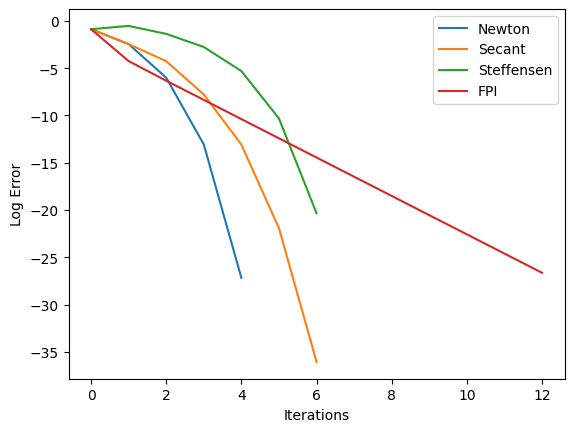

In [ ]:
L = lambda X: list(range(len(X)))

tol=1e-10
r1 = np.log(np.abs(NewtonRoot(g,dg,1,tol=tol,log=True)-np.sqrt(2))[:-1])
r2 = np.log(np.abs(SecantRoot(g,1,tol=tol,log=True)-np.sqrt(2))[:-1])
r3 = np.log(np.abs(Steffensen(g,1,tol=tol,log=True)-np.sqrt(2))[:-2])
r4 = np.log(np.abs(FPI(g,0.4,1,tol=tol,log=True)-np.sqrt(2)))

plt.plot(L(r1),r1,label="Newton")
plt.plot(L(r2),r2,label="Secant")
plt.plot(L(r3),r3,label="Steffensen")
plt.plot(L(r4),r4,label="FPI")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Log Error")
plt.show()

## Numerical Linear Algebra

In [ ]:
def systemError(x,A,b):
  return ((A.dot(x)-b)**2).sum()**0.5

def norm2(x,y):
  return ((x-y)**2).sum()**0.5

### Gaussian Elimination
This is what everybody learns in linear algebra, but it is inefficient for large matrices.

In [ ]:
def gaussian_elimination(A,b):
    A = A.copy()
    b = b.copy()
    for i in range(A.shape[1]):
        b[i] = b[i] / A[i,i]
        A[i,:] =  A[i,:]/A[i,i]
        if i < A.shape[1]-1:
            for j in range(i+1,A.shape[1]):
                b[j] = b[j] - A[j,i] * b[i]
                A[j,:] -= A[j,i] * A[i,:]
    for i in range(A.shape[1]-2,-1,-1):
        for j in range(i+1,A.shape[1]):
            b[i] = b[i] - A[i,j]*b[j]
            A[i,:] = A[i,:] - A[i,j] * A[j,:]
    return b

### Jacobi's Method
An iterative method for solving linear systems of equations.

In [ ]:
def diagonal(A):
  return np.diag(np.diagonal(A))


def Jacobi(A, b, N=100, tol=0, log=False):
    n = len(A)
    A2 = diagonal(A)
    A2inv = np.zeros([n,n])
    A2inv[np.diag_indices(n)] = np.reciprocal(A2[np.diag_indices(n)])
    A1 = A - A2
    x = np.zeros(n)
    past = [x]
    count = 0
    while systemError(x,A,b) > tol and count < N:
        x = A2inv.dot(b-A1.dot(x))
        count += 1
        if log: past.append(x)
    return x if not log else np.array(past)

### Gauss-Seidel


In [ ]:
def GaussSeidel(A, b, N=100, tol=0, log=False):
    n = len(A)
    x = np.zeros(n)
    past = [x]
    count = 0
    while systemError(x,A,b) > tol and count < N:
        xk = np.zeros(n)
        for i in range(n):
            s1 = sum([A[i,j]*xk[j] for j in range(i)])
            s2 = sum([A[i,j]*x[j] for j in range(i+1,n)])
            xk[i] = 1/A[i,i]*(b[i] - s1 - s2)
        x = xk
        if log: past.append(xk)
        count += 1
    return x if not log else np.array(past)


### Successive Over-Relaxation

In [ ]:
def SOR(A, b, w, N=100, tol=0, log=False):
    n = len(A)
    x = np.zeros(n)
    past = [x]
    count = 0
    while systemError(x,A,b) > tol and count < N:
        xk = np.zeros(n)
        for i in range(n):
            s1 = sum([A[i,j]*xk[j] for j in range(i)])
            s2 = sum([A[i,j]*x[j] for j in range(i+1,n)])
            xk[i] = w/A[i,i]*(b[i] - s1 - s2) + (1-w)*x[i]
        x = xk
        if log: past.append(xk)
        count += 1
    return x if not log else np.array(past)


### Comparison
Here I use a 5x5 matrix $A$ with image vector $b$ and solve for the true solution $(1,2,3,4)$ to this system.  I also record the time each method takes to solve.

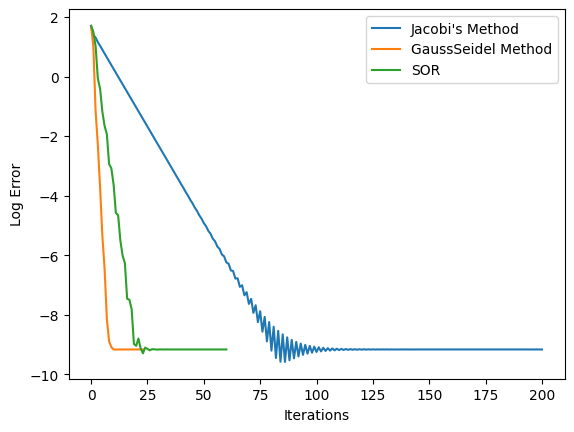

In [ ]:
A = np.array([[2.4117,0.6557,0.6787,0.6555],
              [0.9157,1.8804,0.7577,0.1712],
              [0.7922,0.8491,3.0905,0.7060],
              [0.9595,0.9340,0.3922,2.3175]])
b = np.array([8.3813,7.6345,14.5862,13.2743])

tol = 1e-13

true = np.array([1,2,3,4])
trueError = lambda x: ((x-true)**2).sum()**0.5

X = Jacobi(A,b, N=200, tol=tol, log=True)
eJ = np.log(np.apply_along_axis(trueError, 1, X))

X = GaussSeidel(A,b,N=200, tol=tol, log=True)
eG = np.log(np.apply_along_axis(trueError, 1, X))

X = SOR(A,b,1.5,N=200,tol=tol,log=True)
eS = np.log(np.apply_along_axis(trueError, 1, X))

plt.plot(L(eJ), eJ, label="Jacobi's Method")
plt.plot(L(eG), eG, label="Gauss-Seidel Method")
plt.plot(L(eS), eS, label="SOR")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Log Error")
plt.show()

## Root Finding (Multivariate)

### Newton's Method
This method requires the inverse of the Jacobian.  I implemented the method to use numpy's linear system solver by default, previous methods such as Jacobi's method can be used instead.

In [ ]:
def NewtonMulti(F, J, x0, solver=np.linalg.solve, N=100, tol=0, log=False):
  x0 = np.array(x0)
  x,x0 = x0, math.inf*x0
  past = [x]
  count = 0
  while norm2(x,x0) > tol and count < N:
    x0 = x
    x = x - solver(J(x),F(x))
    if log: past.append(x)
    count += 1
  return x if not log else np.array(past)


### Fixed Point Iteration

In [ ]:
def FPIMulti(F, alpha, x0, N=100, tol=0, log=False):
  x0 = np.array(x0)
  x,x0 = x0,math.inf*x0
  past=[x]
  count = 0
  while norm2(x,x0) > tol and count < N:
    x0 = x
    x = x - alpha*F(x)
    if log: past.append(x)
    count += 1
  return x if not log else np.array(past)

### Comparison
The below compares FPI with Newton's method, using both numpy's solver and the Gauss-Seidel method from above with 10 iterations.  In the plots, both uses of Newton's method are indistinguishable.

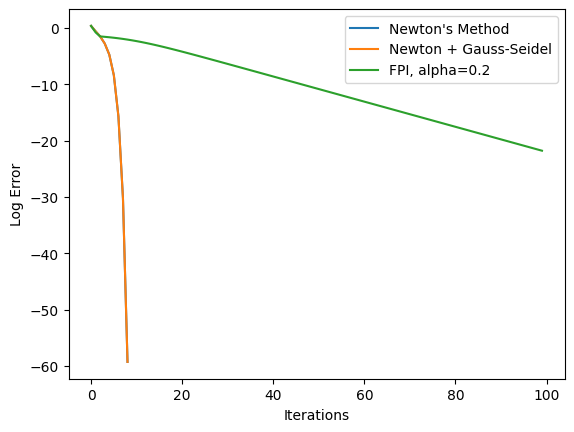

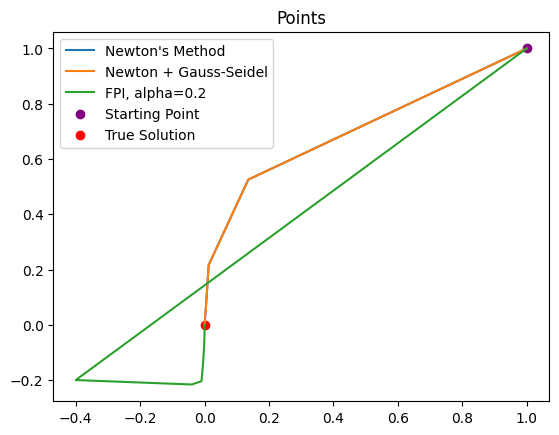

In [ ]:
F = lambda x: np.array([x[0]**2 + x[1]**2 + 5*x[0], 2*x[0]*x[1] + 3*x[1]**2 + x[1]])
J = lambda x: np.array([[2*x[0] + 5, 2*x[1]],
                            [2*x[1], 2*x[0] + 6*x[1] + 1]])

tol = 1e-10
xN = NewtonMulti(F, J, (1,1),tol=tol,log=True)
xF = FPIMulti(F,0.2,(1,1),tol=tol,log=True)
xNG = NewtonMulti(F, J, (1,1), tol=tol, log=True, solver=lambda A,b: GaussSeidel(A,b,N=10))

eN = np.log(np.apply_along_axis(lambda x: norm2(np.zeros(2),x), 1,xN))
eF = np.log(np.apply_along_axis(lambda x: norm2(np.zeros(2),x), 1,xF))
eNG = np.log(np.apply_along_axis(lambda x: norm2(np.zeros(2),x), 1,xNG))

plt.plot(L(xN), eN, label="Newton's Method")
plt.plot(L(xNG),eNG,label="Newton + Gauss-Seidel")
plt.plot(L(xF), eF, label="FPI, alpha=0.2")

plt.legend()
plt.ylabel("Log Error")
plt.xlabel("Iterations")
plt.show()

plt.plot(xN[:,0],xN[:,1], label="Newton's Method")
plt.plot(xNG[:,0],xNG[:,1],label="Newton + Gauss-Seidel")
plt.plot(xF[:,0],xF[:,1], label="FPI, alpha=0.2")

plt.scatter([1],[1],color="purple",label="Starting Point")
plt.scatter([0],[0],color="red",label="True Solution")
plt.legend()
plt.title("Points")
plt.show()

## Polynomial Interpolation
To be added later

## Differentiation

## Quadrature

## Fourier Transform

## Differential Equations